In [28]:
import numpy as np
import networkx as nx
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cartopy.crs as ccrs
import pysbm
import sys  
sys.path.insert(0, './')
import iaaft

# Visualize Distribution of Correlations

In [29]:
data = np.load('../data/data_centered.npy', allow_pickle=True)
print(f"first time series centered mean:{np.round(data[:,0,0].mean(), 10)}")
print(f"first time series centered std:{np.round(data[:,0,0].std(), 10)}")

first time series centered mean:-0.0
first time series centered std:1.0


In [30]:
'''
input: time series data over WE as np array
ouput: graph that contains gridcells as nodes and an edge if correllation is sufficiently high
'''

corr_shift = 0.275
upper_quantile = 0.45
lower_quantile = -0.25
alpha = 0.001

def build_graph(data): 
    t, lon, lat = data.shape[0], data.shape[1], data.shape[2]
    print(f"dimensions: longitude={lon}, latitude={lat}, timeseries={t}")
    graph_pos = nx.Graph()
    
    # create nodes that consist of grid cell coordinates
    for i in range(lon):
        for j in range(lat):
            graph_pos.add_node(i*lat + j)
            graph_pos.nodes[i*lat +j]['pos'] = (1.25 * j -15 ,1.25 * i + 35)
            graph_pos.nodes[i*lat +j]['ind'] = (i,j)
    graph_neg = graph_pos.copy()
    correlations = add_edges(graph_pos, graph_neg, data)
    return graph_pos, graph_neg, correlations

'''
compute correlation coefficient between the two given time series
'''
def add_edges(graph_pos, graph_neg, data): 
    t, lon, lat = data.shape[0], data.shape[1], data.shape[2]
    n = lon*lat
    correlations = np.zeros((n,n))
    nodes = graph_pos.nodes()
    for n1 in nodes:
        ind1 = nodes[n1]['ind']
        t1 = data[:, ind1[0], ind1[1]]
        for n2 in nodes:
            if n2 <= n1: 
                continue
            ind2 = nodes[n2]['ind']
            t2 = data[:, ind2[0], ind2[1]]
            # corrcoef contains correlation matrix
            corr = np.corrcoef(t1, t2)[0][1]
            correlations[n1, n2] = corr
    
    #a = correlations[correlations != 0]
    #upper_quantile = np.quantile(a, q=1-alpha/2)
    #lower_quantile = np.quantile(a, q=alpha/2)
    print(f"upper quantile: {upper_quantile}, lower quantile: {lower_quantile}")
    adjacency_matrix_pos = (correlations - corr_shift) > upper_quantile
    adjacency_matrix_neg = (correlations  + corr_shift) < lower_quantile
    for n1 in nodes:
        for n2 in nodes:
            if adjacency_matrix_pos[n1,n2]:
                graph_pos.add_edge(n1,n2)
            if adjacency_matrix_neg[n1,n2]:
                graph_neg.add_edge(n1,n2)
    return correlations

## Experiments with a downsampled data set

In [31]:
def downsample(data, stride, mean=False):
    if not mean: 
        return data[:, ::stride, ::stride]
    
    I = int(np.ceil(data.shape[1]/stride))
    J = int(np.ceil(data.shape[2]/stride))
    small_data = np.zeros((data.shape[0],I,J))
    for t in range(data.shape[0]):
        for i in range(I):
            for j in range(J):
                upper_y = min( (i+1) * stride, data.shape[1])
                lower_y = upper_y - stride
                upper_x = min( (j+1) * stride, data.shape[2])
                lower_x = upper_x - stride
                small_data[t,i,j] = np.mean(data[t,lower_y:upper_y, lower_x:upper_x])
    return small_data

In [32]:
sampling_rate = 5
small_data = downsample(data, sampling_rate)
print("dimensions of original data set", data.shape)
print("dimensions of downsampled data set: ", small_data.shape)

dimensions of original data set (507, 161, 221)
dimensions of downsampled data set:  (507, 33, 45)


In [33]:
%%time
graph_pos, graph_neg, correlations = build_graph(small_data)

n = graph_pos.number_of_nodes()
m = graph_pos.number_of_edges()
print("number of nodes", n)
print("number of edges", m)
print("ratio edges/possible edges in graph_pos", m/(n*(n-1)*0.5))

dimensions: longitude=33, latitude=45, timeseries=507
upper quantile: 0.45, lower quantile: -0.25
number of nodes 1485
number of edges 27816
ratio edges/possible edges in graph_pos 0.02524435731982902
Wall time: 2min 9s


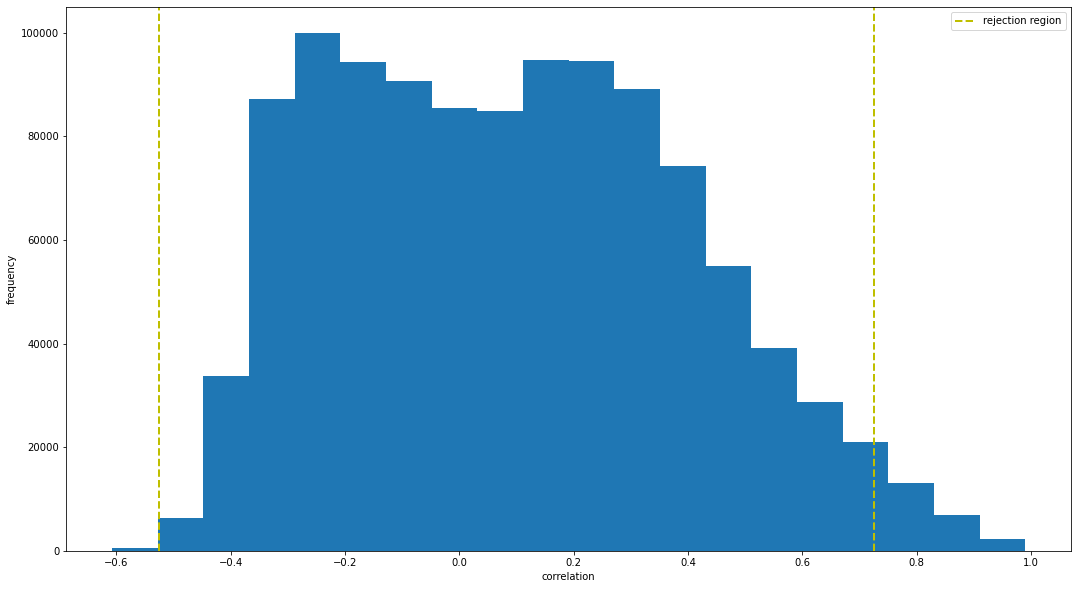

In [34]:
plt.hist(correlations[correlations!=0].flatten(), bins=20)
plt.axvline(upper_quantile + corr_shift, color='y', linestyle='dashed', linewidth=2, label="rejection region")
plt.axvline(lower_quantile - corr_shift, color='y', linestyle='dashed', linewidth=2)
plt.ylabel("frequency")
plt.xlabel("correlation")
plt.legend()

plt.savefig('../plots/correlations.svg', format="svg")
plt.savefig('../plots/correlations.jpg')

plt.show()

In [35]:
def plot_graph(graph, title, edge_thickness=0.3, node_thickness=20, save_as=None):
    plt.rcParams["figure.figsize"] = (18,10)
    if save_as is None: 
        save_as = title
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()
    
    pos=nx.get_node_attributes(graph,'pos')
    node_size = [np.log(graph.degree[i]+0.5)*node_thickness for i in list(graph.nodes())]
    nx.draw_networkx_nodes(graph, pos=pos,node_size=node_size)
    nx.draw_networkx_edges(graph, pos=pos,width=edge_thickness)

    plt.title(title, fontsize=15)
    plt.savefig(f'../plots/{save_as}.svg', format="svg")
    plt.savefig(f'../plots/{save_as}.jpg')
    plt.show()

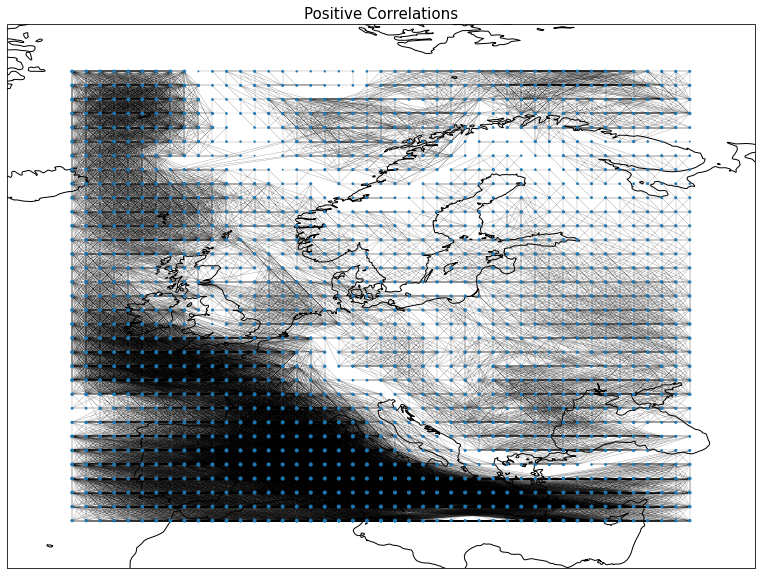

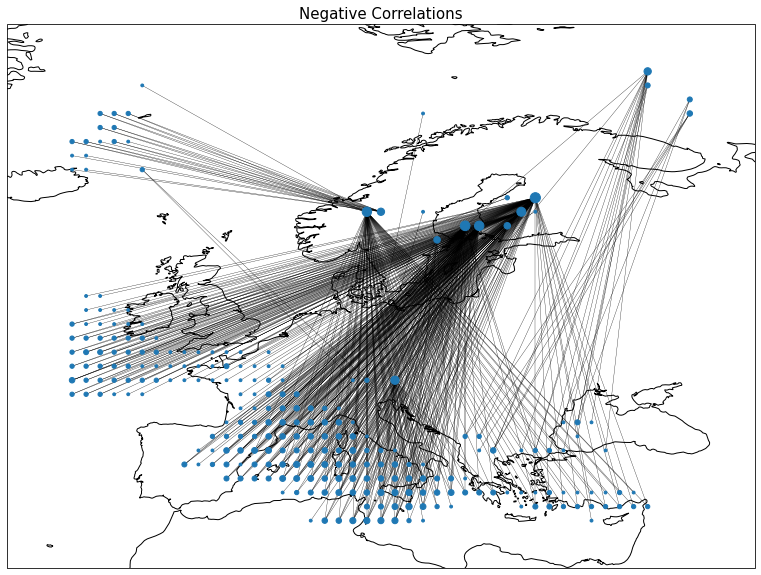

In [36]:
plot_graph(graph_pos, edge_thickness=0.15, node_thickness=2, title="Positive Correlations", save_as='positive_correlations')
plot_graph(graph_neg, title="Negative Correlations", save_as='negative_correlations')

## Infer Communities

In [37]:
k_pos = 5
k_neg = 4


def infer_communities(graph, K, iterations = 5):
    
    standard_partition = pysbm.NxPartition(graph=graph,number_of_blocks=K)
    standard_objective_function = pysbm.TraditionalUnnormalizedLogLikelyhood(is_directed=False)
    
    best_objective = -np.inf
    for r in range(iterations):
        standard_partition = pysbm.NxPartition(graph=graph,number_of_blocks=K)
        standard_inference = pysbm.KarrerInference(graph, standard_objective_function, standard_partition)
        standard_inference.infer_stochastic_block_model()
        L=standard_objective_function.calculate(standard_partition)
        if L>best_objective:
            best_objective=L
            best_partition = standard_partition
        print(f'\tIteration {r} - Best objective value: {best_objective}, Current objective value: {L}')
    return best_partition

initial_partition_pos = pysbm.NxPartition(graph=graph_pos, number_of_blocks=k_pos)
initial_partition_neg = pysbm.NxPartition(graph=graph_neg, number_of_blocks=k_neg)

partition_pos = infer_communities(graph_pos, k_pos)
partition_neg = infer_communities(graph_neg, k_neg)

	Iteration 0 - Best objective value: -118167.5818714035, Current objective value: -118167.5818714035
	Iteration 1 - Best objective value: -115294.77095903728, Current objective value: -115294.77095903728
	Iteration 2 - Best objective value: -115294.77095903728, Current objective value: -115485.25629320007
	Iteration 3 - Best objective value: -115294.77095903728, Current objective value: -118390.59409791746
	Iteration 4 - Best objective value: -115294.77095903728, Current objective value: -117917.55029188035
	Iteration 0 - Best objective value: -1611.2273345074796, Current objective value: -1611.2273345074796
	Iteration 1 - Best objective value: -1611.2273345074796, Current objective value: -1628.3820115937465
	Iteration 2 - Best objective value: -1565.734811180012, Current objective value: -1565.734811180012
	Iteration 3 - Best objective value: -1565.734811180012, Current objective value: -1628.3820115937465
	Iteration 4 - Best objective value: -1565.734811180012, Current objective val

In [38]:
def plot_communities(graph, partition, title, edge_thickness=0.3, node_thickness=20, save_as=None):
    if save_as is None:
        save_as = title
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()

    pos=nx.get_node_attributes(graph,'pos')
    node_size = [np.log(graph.degree[i]+0.5)*node_thickness for i in list(graph.nodes())]
    nx.draw_networkx_nodes(graph, pos=pos,node_size=node_size, node_color=[colors[partition.get_block_of_node(node)] for node in graph])
    nx.draw_networkx_edges(graph, pos=pos,width=edge_thickness)

    
    plt.title(title, fontsize=15)
    plt.savefig(f'../plots/{save_as}.svg', format="svg")
    plt.savefig(f'../plots/{save_as}.jpg')
    plt.show()

### Show initial communities

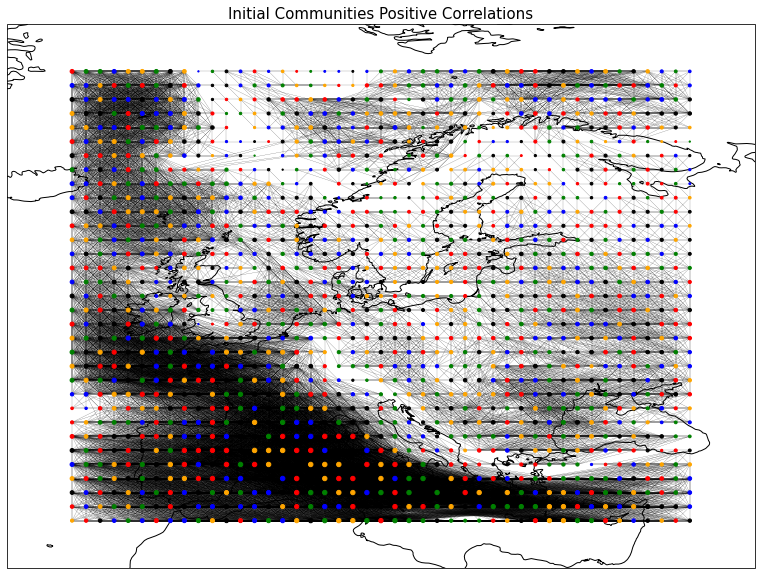

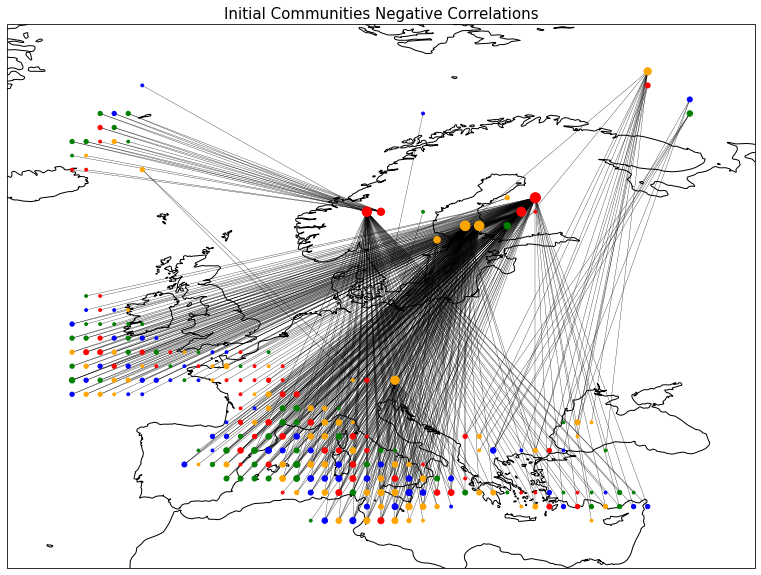

In [39]:
colors = {0:'b',1:'r',2:'g',3:'orange',4:'black',5:'magenta'}

plot_communities(graph_pos, partition=initial_partition_pos, edge_thickness=0.15, node_thickness=4, title="Initial Communities Positive Correlations", save_as='initial_communities_positive_correlations')
plot_communities(graph_neg, partition=initial_partition_neg, title="Initial Communities Negative Correlations", save_as='initial_communities_negative_correlations')

### Show final communities

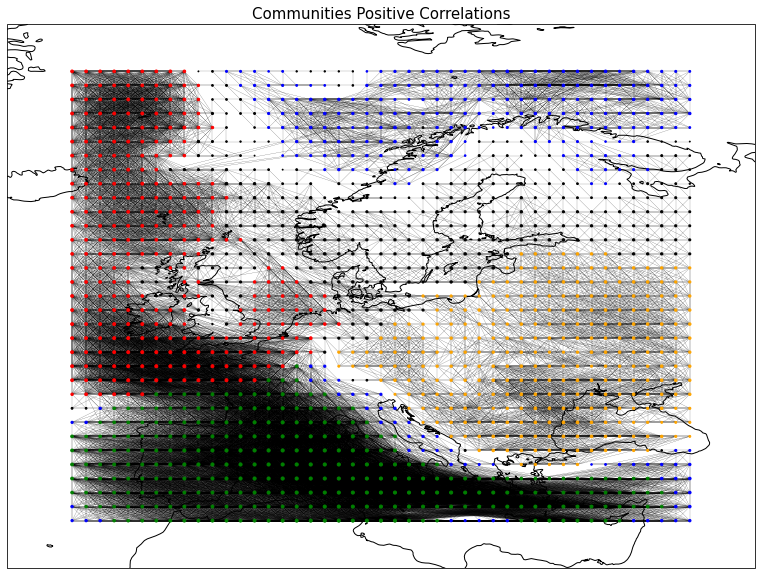

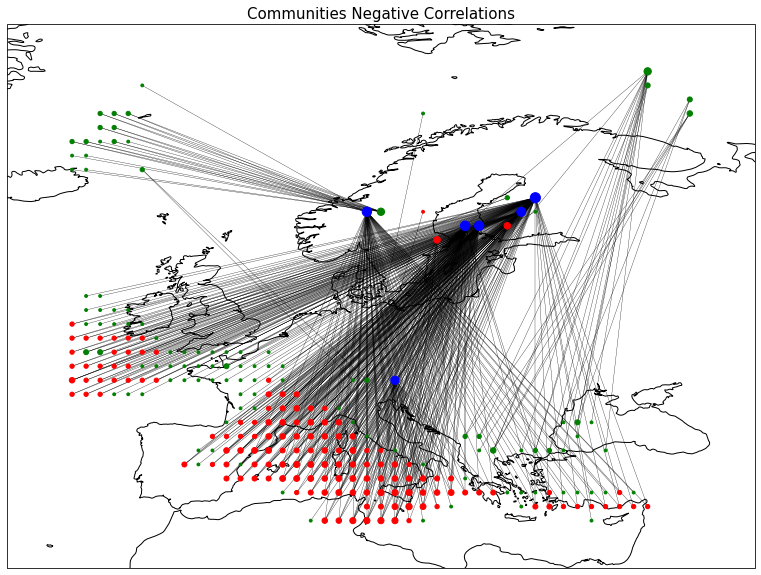

In [40]:
plot_communities(graph_pos, partition_pos, edge_thickness=0.15, node_thickness=2, title="Communities Positive Correlations", save_as='communities_positive_correlations')
plot_communities(graph_neg, partition_neg, title="Communities Negative Correlations", save_as='communities_negative_correlations')

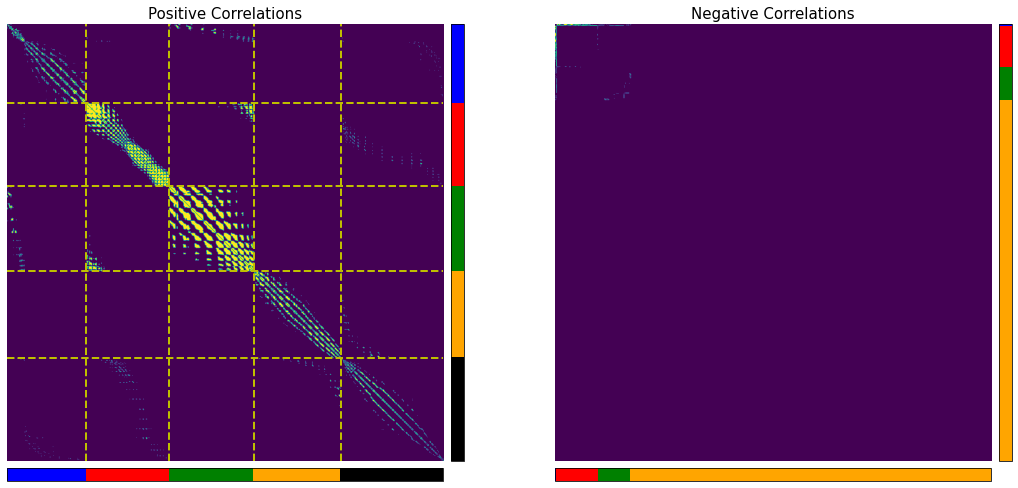

269


In [49]:
def find_groups(partition,graph,K=None):
    if K is None:
        K=partition.B
    groups=[[] for i in range(K)]
    for node in graph:
        q=partition.get_block_of_node(node)
        groups[q].append(node)
    return groups

def ordered_nodelist(partition,graph,K=None):
    groups = find_groups(partition,graph,K=K)
    K = len(groups)
    ordered_nodelist=sum(groups, []) # concatenate groups
    return ordered_nodelist, groups


k_bic_pos = 5
k_bic_neg = 4
fig, axs = plt.subplots(1, 2, figsize=(18, 10))

ord_nodelist, groups = ordered_nodelist(partition_pos, graph_pos, K=k_bic_pos)
bounds = np.concatenate((np.array([0]), np.cumsum([len(group)for group in groups])))

cmap = (mpl.colors.ListedColormap(list(colors.values())[:k_bic_pos]))
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

axs[0].imshow(nx.to_numpy_matrix(graph_pos, nodelist=ord_nodelist))
axs[0].set_title("Positive Correlations", fontsize=15)

divider = make_axes_locatable(axs[0])
cax_right = divider.append_axes('right', size='3%', pad=0.1)
cax_bottom = divider.append_axes('bottom', size='3%', pad=0.1)


for bound in bounds[1:-1]:
    axs[0].axvline(bound, color='y', linestyle='dashed', linewidth=2)
    axs[0].axhline(bound, color='y', linestyle='dashed', linewidth=2)


axs[0].axis('off')
fig.colorbar(
    mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
    cax=cax_right,
    boundaries=bounds,  # Adding values for extensions.
    # extend='both',
    ticks=bounds,
    spacing='proportional',
    orientation='vertical',
    label='Discrete intervals, some other units'
)

fig.colorbar(
    mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
    cax=cax_bottom,
    boundaries=[0] + bounds,  # Adding values for extensions.
    # extend='both',
    ticks=bounds,
    spacing='proportional',
    orientation='horizontal',
    label='Discrete intervals, some other units'
)
cax_right.axis('off')
cax_bottom.axis('off')
cax_right.invert_yaxis()
cax_bottom.invert_yaxis()


ord_nodelist2, groups2 = ordered_nodelist(partition_neg, graph_neg, K=k_bic_neg)
axs[1].imshow(nx.to_numpy_matrix(graph_neg, nodelist=ord_nodelist2))
axs[1].set_title("Negative Correlations", fontsize=15)

divider2 = make_axes_locatable(axs[1])
cax_right2 = divider2.append_axes('right', size='3%', pad=0.1)
cax_bottom2 = divider2.append_axes('bottom', size='3%', pad=0.1)

bounds2 = np.concatenate((np.array([0]), np.cumsum([len(group)for group in groups2])))

cmap_neg = (mpl.colors.ListedColormap(list(colors.values())[:k_bic_neg]))
norm2 = mpl.colors.BoundaryNorm(bounds2, cmap_neg.N)


axs[1].axis('off')
fig.colorbar(
    mpl.cm.ScalarMappable(norm=norm2, cmap=cmap),
    cax=cax_right2,
    boundaries=bounds2,  # Adding values for extensions.
    # extend='both',
    ticks=bounds2,
    spacing='proportional',
    orientation='vertical',
    label='Discrete intervals, some other units'
)

fig.colorbar(
    mpl.cm.ScalarMappable(norm=norm2, cmap=cmap),
    cax=cax_bottom2,
    boundaries=[0] + bounds2,  # Adding values for extensions.
    # extend='both',
    ticks=bounds2,
    spacing='proportional',
    orientation='horizontal',
    label='Discrete intervals, some other units'
)
cax_right2.axis('off')
cax_bottom2.axis('off')
cax_right2.invert_yaxis()
cax_bottom2.invert_yaxis()

#plt.savefig('../plots/adjacency_matrices.svg', format="svg")
#plt.savefig('../plots/adjacency_matrices.jpg')

plt.show()

print(bounds[1])